In [1]:
%load_ext autoreload
%autoreload 2

## Preprocessing
Run to generate the folder for the Torch ImageLoader class

In [ ]:
# find closest image to resistivity timestamp
#def find_closest_image(ts):
    # Given a presorted list of timestamps:  s = sorted(index)
#    i = bisect_left(s, ts)
#    return min(s[max(0, i-1): i+2], key=lambda t: abs(ts - t))

import io
import csv
import shutil
img_folder = 'data/timelapse_images_fast'

with open('data/labels_v2.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        img_name = row[1]
        label = int(row[2]=='True')
        month_folder = row[0][:10]
        #print(month_folder)
        #print(img_name,label)
        #print(os.path.join(img_folder,month_folder,img_name))
        shutil.copyfile(os.path.join(img_folder,month_folder,img_name),os.path.join(img_folder,str(label),img_name))

In [2]:
import os
import torch
import pandas as pd
#from skimage import io, transform
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as Ft

import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler

from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [3]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
class MyCrop(object):
    def __init__(self, size, coord, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'):
        self.size = size
        self.padding = padding
        # center points
        self.coord = coord
        self.pad_if_needed = pad_if_needed
        self.fill = fill
        self.padding_mode = padding_mode

    def _get_image_size(img):
        return img.shape
    
    def __call__(self, img):
        if self.padding is not None:
            img = Ft.pad(img, self.padding, self.fill, self.padding_mode)

        # pad the width if needed
        if self.pad_if_needed and img.size[0] < self.size[1]:
            img = Ft.pad(img, (self.size[1] - img.size[0], 0), self.fill, self.padding_mode)
        # pad the height if needed
        if self.pad_if_needed and img.size[1] < self.size[0]:
            img = Ft.pad(img, (0, self.size[0] - img.size[1]), self.fill, self.padding_mode)
        
        crops = []
        for coord in self.coord:
            crops.append(Ft.crop(img, coord[0], coord[1], self.size, self.size))

        return crops

    def __repr__(self):
        return self.__class__.__name__ + '(size={0}, padding={1})'.format(self.size, self.padding)


In [12]:
opts = {}
opts['epochs'] = 100
opts['batch_size'] = 64
opts['lr'] = 0.003
opts['nr_classes'] = 2

coord = [(155,321),(201,419),(45,460),(121,158)]
TRAIN_DATA_PATH = "./train_data"
TEST_DATA_PATH = "./test_data"
TRANSFORM_IMG = transforms.Compose([
    #transforms.CenterCrop(64),
    MyCrop(64,coord),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    #transforms.Resize(256),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                     std=[0.229, 0.224, 0.225] )
    ])

writer = SummaryWriter()

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)

print(len(train_data.imgs))
# split into (train,val,test)
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(0.05 * dataset_size))
#np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
#train_data_loader = data.DataLoader(train_data, batch_size=opts['batch_size'], sampler=train_sampler,  num_workers=4)
#valid_data_loader = data.DataLoader(train_data, batch_size=opts['batch_size'], sampler=valid_sampler,  num_workers=4)
train_data_loader = data.DataLoader(train_data, batch_size=opts['batch_size'], shuffle=True,  num_workers=4)
valid_data_loader = data.DataLoader(test_data, batch_size=opts['batch_size'], shuffle=False,  num_workers=4)

#train_iter = iter(train_data_loader)
#test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
#test_data_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

17108


## Models

In [13]:
class BinaryCNN(torch.nn.Module):    
    def __init__(self):
        super(BinaryCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 4)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
class CNN2(nn.Module):
    # initializers
    def __init__(self, d=32):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(12, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        #print(self.conv4_bn)
        self.linear = nn.Linear(d*8*4*4,2)
        #self.conv5 = nn.Conv2d(d*8, 4, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = x.reshape(x.size(0), -1)
        #x = F.sigmoid(self.conv5(x))
        x = self.linear(x)

        return x
    
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

## Training loop

In [ ]:
import torch.optim as optim

net = CNN2()
net = net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=opts['lr'])
bins = np.array([0,91,182,273,366])
nr_batches = len(train_data_loader)

for epoch in range(opts['epochs']):  
    running_loss = 0.0
    for i, sample in tqdm(enumerate(train_data_loader, 0)):
        inputs, labels = sample
        inputs_stack = torch.reshape(inputs,[-1,12,64,64]).cuda()
        labels = labels.cuda()
        # quantize labels to 4 bins
        #labels_q = torch.tensor(np.digitize(labels,bins))
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs_stack)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        
        # tensorboard 
        writer.add_scalar('Loss/train', loss, epoch*nr_batches + i)
    
    # run on test set
    test_losses = []
    best_loss = 10
    correct = 0
    total = 0
    for i, test_sample in tqdm(enumerate(valid_data_loader, 0)):
        test_inputs, test_labels = test_sample
        test_inputs_stack = torch.reshape(test_inputs,[-1,12,64,64]).cuda()
        test_labels = test_labels.cuda()

        # forward
        test_outputs = net(test_inputs_stack)
        test_loss = criterion(test_outputs, test_labels)
        _, predicted = torch.max(test_outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()
        test_losses.append(test_loss)
    
    print("Test accuracy: ", correct/total)
    avg_test_loss = torch.mean(torch.stack(test_losses))
    writer.add_scalar('Loss/test', avg_test_loss, epoch)
    writer.add_scalar('Loss/acc', correct/total, epoch)

    if(avg_test_loss < best_loss and epoch > 5):
        torch.save(net.state_dict(), os.path.join('models','best.th'))
    
print('Finished Training')

268it [00:16, 15.78it/s]
9it [00:00, 11.92it/s]

Test accuracy:  0.4963768115942029



268it [00:16, 15.77it/s]
9it [00:00, 11.19it/s]

Test accuracy:  0.4855072463768116



268it [00:16, 15.79it/s]
9it [00:00, 12.05it/s]

Test accuracy:  0.5054347826086957



268it [00:16, 15.79it/s]
9it [00:00, 12.00it/s]

Test accuracy:  0.37681159420289856



268it [00:16, 15.84it/s]
9it [00:00, 12.08it/s]

Test accuracy:  0.3804347826086957



57it [00:03, 15.56it/s]

## Load trained model and test it visually on a batch

/home/ivan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Predicted label:  tensor(0)
True label:  tensor(0)


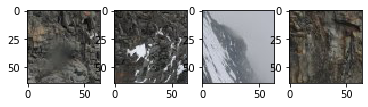

Press key for next sample 


Predicted label:  tensor(0)
True label:  tensor(0)


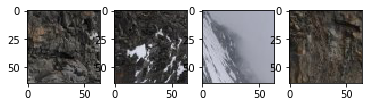

Press key for next sample 


Predicted label:  tensor(1)
True label:  tensor(0)


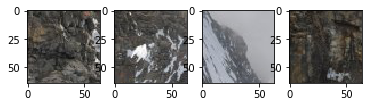

Press key for next sample 


Predicted label:  tensor(0)
True label:  tensor(0)


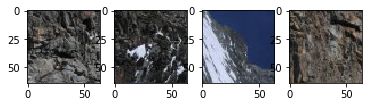

Press key for next sample 


Predicted label:  tensor(0)
True label:  tensor(0)


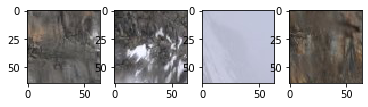

Press key for next sample 


Predicted label:  tensor(0)
True label:  tensor(0)


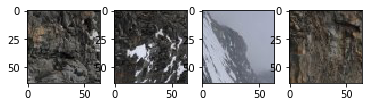

Press key for next sample 


Predicted label:  tensor(1)
True label:  tensor(0)


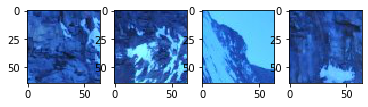

Press key for next sample 


Predicted label:  tensor(0)
True label:  tensor(0)


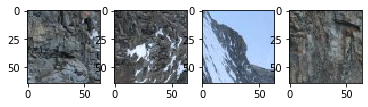

Press key for next sample 


Predicted label:  tensor(1)
True label:  tensor(0)


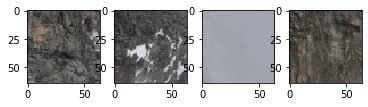

Press key for next sample 


Predicted label:  tensor(0)
True label:  tensor(0)


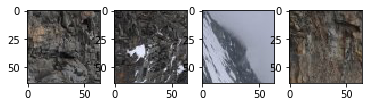

Press key for next sample 


Predicted label:  tensor(1)
True label:  tensor(0)


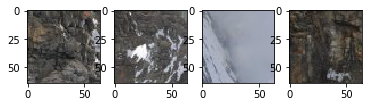

Press key for next sample 


Predicted label:  tensor(0)
True label:  tensor(0)


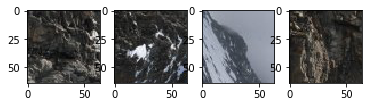

Press key for next sample 


Predicted label:  tensor(0)
True label:  tensor(0)


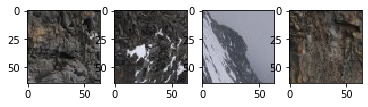

KeyboardInterrupt: 

In [11]:
model = CNN2()
model.load_state_dict(torch.load('models/best.th'))
for batch_idx, sample in enumerate(valid_data_loader):
    images, labels = sample
    test_images_stack = torch.reshape(images,[-1,12,64,64])

    test_labels = model(test_images_stack)
    softmaxlbl = F.softmax(test_labels)
    for i in range(opts['batch_size']):
        print("Predicted label: ", torch.argmax(softmaxlbl[i]))
        print("True label: ", labels[i])
        f, axarr = plt.subplots(1,4)

        axarr[0].imshow(images[i][0].permute(1, 2, 0))
        axarr[1].imshow(images[i][1].permute(1, 2, 0))
        axarr[2].imshow(images[i][2].permute(1, 2, 0))
        axarr[3].imshow(images[i][3].permute(1, 2, 0))
        plt.show()
        #for j in range(4):
        #    plt.imshow(  sample[0][0][j].permute(1, 2, 0)  )
        #    plt.show()
        input("Press key for next sample")

## Misc

In [ ]:
#import seaborn as sns
#data = pd.read_csv("data/timeseries_derived_data_products/MH11_resistivity_rock_2017.csv") 
# Preview the first 5 lines of the loaded data 
data = pd.read_csv("data/labels.csv") 
#pd.DataFrame.plot.line(data)
data

In [ ]:
labels = np.array([2,30,330,102,35,67,82,230])
bins = np.array([1,90,180,270,360])
np.histogram(labels, bins)
np.digitize(labels,bins)

In [ ]:
for batch_idx, sample in enumerate(train_data_loader):
    images, labels = sample
    labels_q = np.digitize(labels,bins)
    plt.imshow(  sample[0][0].permute(1, 2, 0)  )


In [ ]:
max_val = 0
min_val = 100
for i, sample in tqdm(enumerate(train_data_loader, 0)):
    max_tmp = torch.max(sample[1])
    min_tmp = torch.min(sample[1])

    if max_tmp > max_val:
        max_val = max_tmp
    if min_tmp < min_val:
        min_val = min_tmp

print(max_val)
print(min_val)

In [ ]:
resnet18 = models.resnet18()

In [ ]:
for batch_idx, sample in enumerate(train_data_loader):
    images, labels = sample
    print(images[0].shape)
    #labels_q = np.digitize(labels,bins)
    for i in range(4):
        plt.imshow(  sample[0][0][i].permute(1, 2, 0)  )
        plt.show()
    break;
